Imports for Local

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna, joblib, matplotlib, os, pyfolio, sys
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from pyfolio import timeseries

matplotlib.use('Agg')
%matplotlib inline
import datetime
from stockstats import StockDataFrame as Sdf
from QuantumAI.config import config
from QuantumAI.config import config_tickers
from QuantumAI.preprocessors.yahoodownloader import YahooDownloader
from QuantumAI.preprocessors.preprocessors import FeatureEngineer, data_split
# from QuantumAI.env.env_portfolio import StockPortfolioEnv
from QuantumAI.env.env_portfolio import StockPortfolioEnv
from QuantumAI.models.models import DRLAgent
from QuantumAI.plot.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts, show_weight_distribution
from QuantumAI.preprocessors.data_processor import DataProcessor
from QuantumAI.preprocessors.processor_yahoofinance import YahooFinanceProcessor


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Imports for Colab

In [2]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import optuna, joblib, matplotlib
# from stable_baselines3 import A2C
# from stable_baselines3.common.evaluation import evaluate_policy

# matplotlib.use('Agg')
# %matplotlib inline
# import datetime
# from stockstats import StockDataFrame as Sdf
# from quantumai.config import config
# from quantumai.config import config_tickers
# from quantumai.preprocessors.yahoodownloader import YahooDownloader
# from quantumai.preprocessors.preprocessors import FeatureEngineer, data_split
# from quantumai.env.env_portfolio import StockPortfolioEnv
# from quantumai.models.models import DRLAgent
# from quantumai.plot.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
# from quantumai.preprocessors.data_processor import DataProcessor
# from quantumai.preprocessors.processor_yahoofinance import YahooFinanceProcessor
# import sys
# sys.path.append("../FinRL-Library")
# sys.path.append("../quantumai")

In [3]:
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [21]:
full_start_date="2004-01-01"
full_end_date="2023-07-19"
train_start_date="2005-07-01"
train_end_date="2015-12-31"
validate_start_date="2011-01-01"
validate_end_date="2015-12-31"
test_start_date="2016-01-01"
test_end_date="2023-07-19"
etf_list =["SPY","QQQ","IWM","EEM"]
flo_ticker = ["AAPL","MSFT", "NVDA", "INTC","GOOGL","TSLA","DAL"]
indices = ["^NDX","^SPX"]

In [5]:
dp = YahooFinanceProcessor()
df = dp.download_data_flo(start_date=full_start_date, end_date=full_end_date, ticker_list=indices, time_interval="1D")
df = df.rename(columns={"timestamp":"date"})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
      timestamp         open         high          low        close  \
0    2004-01-02  1474.160034  1479.589966  1458.510010  1463.569946   
1    2004-01-05  1474.550049  1496.579956  1474.189941  1496.579956   
2    2004-01-06  1492.410034  1504.469971  1486.589966  1501.260010   
3    2004-01-07  1498.380005  1514.449951  1491.199951  1514.260010   
4    2004-01-08  1524.060059  1530.650024  1513.339966  1530.650024   
...         ...          ...          ...          ...          ...   
9831 2023-07-12  4467.689941  4488.339844  4463.229980  4472.160156   
9832 2023-07-13  4491.500000  4517.379883  4489.359863  4510.040039   
9833 2023-07-14  4514.609863  4527.759766  4499.560059  4505.419922   
9834 2023-07-17  4508.859863  4532.850098  4504.899902  4522.790039   
9835 2023-07-18  4521.779785  4562.299805  4514.589844  4554.979980   

         

In [6]:
df

,date,open,high,low,close,volume,tic
0,2004-01-02,1474.160034,1479.589966,1458.510010,1463.569946,1666780000,^NDX
1,2004-01-05,1474.550049,1496.579956,1474.189941,1496.579956,2362910000,^NDX
2,2004-01-06,1492.410034,1504.469971,1486.589966,1501.260010,2273220000,^NDX
3,2004-01-07,1498.380005,1514.449951,1491.199951,1514.260010,2294280000,^NDX
4,2004-01-08,1524.060059,1530.650024,1513.339966,1530.650024,2683950000,^NDX
...,...,...,...,...,...,...,...
9831,2023-07-12,4467.689941,4488.339844,4463.229980,4472.160156,3920290000,^SPX
9832,2023-07-13,4491.500000,4517.379883,4489.359863,4510.040039,3839530000,^SPX
9833,2023-07-14,4514.609863,4527.759766,4499.560059,4505.419922,3647450000,^SPX
9834,2023-07-17,4508.859863,4532.850098,4504.899902,4522.790039,3538240000,^SPX


In [7]:
df.index = df.date.factorize()[0]
lookrange=252

In [8]:
df = df.sort_values(by=["tic", "date"])
df
stock = Sdf.retype(df.copy())
stock
unique_ticker = stock.tic.unique()
unique_ticker

array(['^NDX', '^SPX'], dtype=object)

In [9]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values
  cov_list.append(covs)


df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [22]:
train = data_split(df, train_start_date, train_end_date)
validate = data_split(df, validate_start_date, validate_end_date)

In [23]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 2, State Space: 2


In [12]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

df = fe.preprocess_data(df)
df

Successfully added technical indicators


,date,open,high,low,close,volume,tic,cov_list,return_list,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2005-01-03,1628.750000,1635.449951,1598.790039,1603.510010,2193130000,^NDX,"[[0.0001350404739962492, 7.129525538146268e-05...",tic ^NDX ^SPX date ...,0.000000,1632.472345,1542.867621,0.000000,-66.666667,100.000000,1603.510010,1603.510010
4666,2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1510800000,^SPX,"[[0.0001350404739962492, 7.129525538146268e-05...",tic ^NDX ^SPX date ...,0.000000,1632.472345,1542.867621,0.000000,-66.666667,100.000000,1202.079956,1202.079956
1,2005-01-04,1611.219971,1612.780029,1565.020020,1571.829956,2690460000,^NDX,"[[0.00013468541681345027, 7.118356097241321e-0...",tic ^NDX ^SPX date ...,-0.710770,1632.472345,1542.867621,0.000000,-66.666667,100.000000,1587.669983,1587.669983
4667,2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1721000000,^SPX,"[[0.00013468541681345027, 7.118356097241321e-0...",tic ^NDX ^SPX date ...,-0.314774,1214.906288,1175.223717,0.000000,-66.666667,100.000000,1195.065002,1195.065002
2,2005-01-05,1568.680054,1580.880005,1562.640015,1563.760010,2375380000,^NDX,"[[0.0001347676256213621, 7.125440774902197e-05...",tic ^NDX ^SPX date ...,-1.155911,1621.722306,1537.677678,0.000000,-79.061244,100.000000,1579.699992,1579.699992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,2023-07-14,4514.609863,4527.759766,4499.560059,4505.419922,3647450000,^SPX,"[[0.00025592778694608277, 0.000184899546954565...",tic ^NDX ^SPX date ...,54.119797,4511.970250,4318.061635,64.840998,160.431578,45.519715,4376.739632,4258.421989
4664,2023-07-17,15608.280273,15745.669922,15576.509766,15713.280273,4593160000,^NDX,"[[0.000256179111053543, 0.00018503295084695742...",tic ^NDX ^SPX date ...,289.460806,15633.403361,14620.150838,69.195508,194.632164,47.293370,14979.642741,14215.867904
9330,2023-07-17,4508.859863,4532.850098,4504.899902,4522.790039,3538240000,^SPX,"[[0.000256179111053543, 0.00018503295084695742...",tic ^NDX ^SPX date ...,56.535778,4528.130944,4311.595961,65.660152,161.293743,46.367800,4386.798633,4264.559823
4665,2023-07-18,15671.719727,15895.679688,15607.709961,15841.349609,4824070000,^NDX,"[[0.0002552126625492036, 0.0001839557724839668...",tic ^NDX ^SPX date ...,311.779956,15762.764125,14566.533043,70.293668,201.291062,51.883266,15022.799740,14263.457389


In [13]:
# df.index = df.date.factorize()[0]
# lookrange=252
# for i in range(lookrange,len(df.index.unique())):
#   data_lookback = df.loc[i-lookrange:i,:]
#   print(data_lookback)


In [24]:
train = data_split(df, train_start_date, train_end_date)
validate = data_split(df, validate_start_date, validate_end_date)

In [15]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 2, State Space: 2


In [16]:
# import numpy as np
# import pandas as pd
# from gym.utils import seeding
# import gym
# from gym import spaces
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# from stable_baselines3.common.vec_env import DummyVecEnv


# class StockPortfolioEnv(gym.Env):
#     """A single stock trading environment for OpenAI gym

#     Attributes
#     ----------
#         df: DataFrame
#             input data
#         stock_dim : int
#             number of unique stocks
#         hmax : int
#             maximum number of shares to trade
#         initial_amount : int
#             start money
#         transaction_cost_pct: float
#             transaction cost percentage per trade
#         reward_scaling: float
#             scaling factor for reward, good for training
#         state_space: int
#             the dimension of input features
#         action_space: int
#             equals stock dimension
#         tech_indicator_list: list
#             a list of technical indicator names
#         turbulence_threshold: int
#             a threshold to control risk aversion
#         day: int
#             an increment number to control date

#     Methods
#     -------
#     _sell_stock()
#         perform sell action based on the sign of the action
#     _buy_stock()
#         perform buy action based on the sign of the action
#     step()
#         at each step the agent will return actions, then
#         we will calculate the reward, and return the next observation.
#     reset()
#         reset the environment
#     render()
#         use render to return other functions
#     save_asset_memory()
#         return account value at each time step
#     save_action_memory()
#         return actions/positions at each time step


#     """
#     metadata = {'render.modes': ['human']}

#     def __init__(self,
#                 df,
#                 stock_dim,
#                 hmax,
#                 initial_amount,
#                 transaction_cost_pct,
#                 reward_scaling,
#                 state_space,
#                 action_space,
#                 tech_indicator_list,
#                 turbulence_threshold=None,
#                 lookback=252,
#                 day = 0):
#         #super(StockEnv, self).__init__()
#         #money = 10 , scope = 1
#         self.day = day
#         self.lookback=lookback
#         self.df = df
#         self.stock_dim = stock_dim
#         self.hmax = hmax
#         self.initial_amount = initial_amount
#         self.transaction_cost_pct =transaction_cost_pct
#         self.reward_scaling = reward_scaling
#         self.state_space = state_space
#         self.action_space = action_space
#         self.tech_indicator_list = tech_indicator_list

#         # action_space normalization and shape is self.stock_dim
#         self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))
#         # Shape = (34, 30)
#         # covariance matrix + technical indicators
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))

#         # load data from a pandas dataframe
#         self.data = self.df.loc[self.day,:]
#         self.covs = self.data['cov_list'].values[0]

#         self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)


#         self.terminal = False
#         self.turbulence_threshold = turbulence_threshold
#         # initalize state: inital portfolio return + individual stock return + individual weights
#         self.portfolio_value = self.initial_amount

#         # memorize portfolio value each step
#         self.asset_memory = [self.initial_amount]
#         # memorize portfolio return each step
#         self.portfolio_return_memory = [0]
#         self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
#         self.date_memory=[self.data.date.unique()[0]]


#     def step(self, actions):
#         # print(self.day)
#         self.terminal = self.day >= len(self.df.index.unique())-1
#         # print(actions)

#         if self.terminal:
#             df = pd.DataFrame(self.portfolio_return_memory)
#             df.columns = ['daily_return']
#             plt.plot(df.daily_return.cumsum(),'r')
#             plt.savefig('results/cumulative_reward.png')
#             plt.close()

#             plt.plot(self.portfolio_return_memory,'r')
#             plt.savefig('results/rewards.png')
#             plt.close()

#             print("=================================")
#             print("begin_total_asset:{}".format(self.asset_memory[0]))
#             print("end_total_asset:{}".format(self.portfolio_value))

#             df_daily_return = pd.DataFrame(self.portfolio_return_memory)
#             df_daily_return.columns = ['daily_return']
#             if df_daily_return['daily_return'].std() !=0:
#               sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
#                        df_daily_return['daily_return'].std()
#               print("Sharpe: ",sharpe)
#             print("=================================")

#             return self.state, self.reward, self.terminal,{}

#         else:
#             #print("Model actions: ",actions)
#             # actions are the portfolio weight
#             # normalize to sum of 1
#             #if (np.array(actions) - np.array(actions).min()).sum() != 0:
#             #  norm_actions = (np.array(actions) - np.array(actions).min()) / (np.array(actions) - np.array(actions).min()).sum()
#             #else:
#             #  norm_actions = actions
#             weights = self.softmax_normalization(actions)
#             #print("Normalized actions: ", weights)
#             self.actions_memory.append(weights)
#             last_day_memory = self.data

#             #load next state
#             self.day += 1
#             self.data = self.df.loc[self.day,:]
#             self.covs = self.data['cov_list'].values[0]
#             self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
#             #print(self.state)
#             # calcualte portfolio return
#             # individual stocks' return * weight
#             portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)
#             # update portfolio value
#             new_portfolio_value = self.portfolio_value*(1+portfolio_return)
#             self.portfolio_value = new_portfolio_value

#             # save into memory
#             self.portfolio_return_memory.append(portfolio_return)
#             self.date_memory.append(self.data.date.unique()[0])
#             self.asset_memory.append(new_portfolio_value)

#             # the reward is the new portfolio value or end portfolo value
#             self.reward = new_portfolio_value
#             #print("Step reward: ", self.reward)
#             #self.reward = self.reward*self.reward_scaling

#         return self.state, self.reward, self.terminal, {}

#     def reset(self):
#         self.asset_memory = [self.initial_amount]
#         self.day = 0
#         self.data = self.df.loc[self.day,:]
#         # load states
#         self.covs = self.data['cov_list'].values[0]


#         self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
#         self.portfolio_value = self.initial_amount
#         #self.cost = 0
#         #self.trades = 0
#         self.terminal = False
#         self.portfolio_return_memory = [0]
#         self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
#         self.date_memory=[self.data.date.unique()[0]]
#         return self.state

#     def render(self, mode='human'):
#         return self.state

#     def softmax_normalization(self, actions):
#         numerator = np.exp(actions)
#         denominator = np.sum(np.exp(actions))
#         softmax_output = numerator/denominator
#         return softmax_output


#     def save_asset_memory(self):
#         date_list = self.date_memory
#         portfolio_return = self.portfolio_return_memory
#         #print(len(date_list))
#         #print(len(asset_list))
#         df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})
#         return df_account_value

#     def save_action_memory(self):
#         # date and close price length must match actions length
#         date_list = self.date_memory
#         df_date = pd.DataFrame(date_list)
#         df_date.columns = ['date']

#         action_list = self.actions_memory
#         df_actions = pd.DataFrame(action_list)
#         df_actions.columns = self.data.tic.values
#         df_actions.index = df_date.date
#         #df_actions = pd.DataFrame({'date':date_list,'actions':action_list})
#         return df_actions

#     def _seed(self, seed=None):
#         self.np_random, seed = seeding.np_random(seed)
#         return [seed]

#     def get_sb_env(self):
#         e = DummyVecEnv([lambda: self])
#         obs = e.reset()
#         return e, obs

In [25]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
#!FLO New validation set
e_validate_gym = StockPortfolioEnv(df = validate, **env_kwargs)

self.oberservation_space.shape (10, 2)
self.data         date         open         high          low        close      volume  \
0 2005-07-01  1497.020020  1501.949951  1489.739990  1490.530029  1176200000   
0 2005-07-01  1191.329956  1197.890015  1191.329956  1194.439941  1593820000   

    tic                                           cov_list  \
0  ^NDX  [[0.00010987045336630049, 6.15346909804649e-05...   
0  ^SPX  [[0.00010987045336630049, 6.15346909804649e-05...   

                                         return_list      macd      boll_ub  \
0  tic             ^NDX      ^SPX
date           ... -4.283794  1556.785415   
0  tic             ^NDX      ^SPX
date           ...  1.739268  1218.816522   

       boll_lb     rsi_30      cci_30      dx_30  close_30_sma  close_60_sma  
0  1487.008604  46.965103 -181.377840  20.250030   1529.619006   1489.682843  
0  1185.331440  50.961863  -62.461079   7.293845   1199.970988   1182.252325  
self.stape.shape (10, 2)
self.oberservation_spac

In [18]:
df

,date,open,high,low,close,volume,tic,cov_list,return_list,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2005-01-03,1628.750000,1635.449951,1598.790039,1603.510010,2193130000,^NDX,"[[0.0001350404739962492, 7.129525538146268e-05...",tic ^NDX ^SPX date ...,0.000000,1632.472345,1542.867621,0.000000,-66.666667,100.000000,1603.510010,1603.510010
4666,2005-01-03,1211.920044,1217.800049,1200.319946,1202.079956,1510800000,^SPX,"[[0.0001350404739962492, 7.129525538146268e-05...",tic ^NDX ^SPX date ...,0.000000,1632.472345,1542.867621,0.000000,-66.666667,100.000000,1202.079956,1202.079956
1,2005-01-04,1611.219971,1612.780029,1565.020020,1571.829956,2690460000,^NDX,"[[0.00013468541681345027, 7.118356097241321e-0...",tic ^NDX ^SPX date ...,-0.710770,1632.472345,1542.867621,0.000000,-66.666667,100.000000,1587.669983,1587.669983
4667,2005-01-04,1202.079956,1205.839966,1185.390015,1188.050049,1721000000,^SPX,"[[0.00013468541681345027, 7.118356097241321e-0...",tic ^NDX ^SPX date ...,-0.314774,1214.906288,1175.223717,0.000000,-66.666667,100.000000,1195.065002,1195.065002
2,2005-01-05,1568.680054,1580.880005,1562.640015,1563.760010,2375380000,^NDX,"[[0.0001347676256213621, 7.125440774902197e-05...",tic ^NDX ^SPX date ...,-1.155911,1621.722306,1537.677678,0.000000,-79.061244,100.000000,1579.699992,1579.699992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329,2023-07-14,4514.609863,4527.759766,4499.560059,4505.419922,3647450000,^SPX,"[[0.00025592778694608277, 0.000184899546954565...",tic ^NDX ^SPX date ...,54.119797,4511.970250,4318.061635,64.840998,160.431578,45.519715,4376.739632,4258.421989
4664,2023-07-17,15608.280273,15745.669922,15576.509766,15713.280273,4593160000,^NDX,"[[0.000256179111053543, 0.00018503295084695742...",tic ^NDX ^SPX date ...,289.460806,15633.403361,14620.150838,69.195508,194.632164,47.293370,14979.642741,14215.867904
9330,2023-07-17,4508.859863,4532.850098,4504.899902,4522.790039,3538240000,^SPX,"[[0.000256179111053543, 0.00018503295084695742...",tic ^NDX ^SPX date ...,56.535778,4528.130944,4311.595961,65.660152,161.293743,46.367800,4386.798633,4264.559823
4665,2023-07-18,15671.719727,15895.679688,15607.709961,15841.349609,4824070000,^NDX,"[[0.0002552126625492036, 0.0001839557724839668...",tic ^NDX ^SPX date ...,311.779956,15762.764125,14566.533043,70.293668,201.291062,51.883266,15022.799740,14263.457389


In [19]:
state_space

2

In [26]:
env_train, _ = e_train_gym.get_sb_env()
#!FLO New validation set
env_validate, _ = e_validate_gym.get_sb_env()
print(type(env_train))

self.state.shape in reset: (10, 2)


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


ValueError: too many values to unpack (expected 2)

In [ ]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS, tensorboard_log='/Users/floriankockler/Documents/GitHub.nosync/TrainedModels/TensorboardLogs/')

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c_etf',
                                total_timesteps=50000)

Logging to /Users/floriankockler/Documents/GitHub.nosync/TrainedModels/TensorboardLogs/a2c_etf_30
-------------------------------------
| time/                 |           |
|    fps                | 1253      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -5.66     |
|    explained_variance | 5.96e-08  |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 2.44e+07  |
|    reward             | 1308689.1 |
|    std                | 0.997     |
|    value_loss         | 1.82e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 1388      |
|    iterations         | 200       |
|    time_elapsed       | 0         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -5

In [ ]:
trained_a2c.save('/Users/floriankockler/Documents/GitHub.nosync/TrainedModels//trained_a2c_etf.zip')

Trading

In [ ]:
trade = data_split(df,test_start_date, test_end_date)
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)


In [ ]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_trade_gym)


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


begin_total_asset:1000000
end_total_asset:2079613.4640418214
Sharpe:  0.5896313106879464
hit end!


In [ ]:
df_actions.to_csv('df_actions.csv')
df_actions

,EEM,IWM,QQQ,SPY
date,,,,
2016-01-04,0.250000,0.250000,0.250000,0.250000
2016-01-05,0.300201,0.233266,0.233266,0.233266
2016-01-06,0.300203,0.233266,0.233266,0.233266
2016-01-07,0.300203,0.233266,0.233266,0.233266
2016-01-08,0.298281,0.254216,0.223752,0.223752
...,...,...,...,...
2023-07-12,0.322960,0.221527,0.233987,0.221527
2023-07-13,0.301809,0.218228,0.261736,0.218228
2023-07-14,0.296913,0.213101,0.276886,0.213101


Backtest

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [ ]:
df_daily_return

,date,daily_return
0,2016-01-04,0.000000
1,2016-01-05,0.001170
2,2016-01-06,-0.014478
3,2016-01-07,-0.028397
4,2016-01-08,-0.011869
...,...,...
1892,2023-07-12,0.014372
1893,2023-07-13,0.011868
1894,2023-07-14,-0.003929
1895,2023-07-17,0.005963


In [ ]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.102151
Cumulative returns      1.079613
Annual volatility       0.198679
Sharpe ratio            0.589631
Calmar ratio            0.307363
Stability               0.779216
Max drawdown           -0.332348
Omega ratio             1.115469
Sortino ratio           0.811289
Skew                   -0.761735
Kurtosis               11.146429
Tail ratio              0.924796
Daily value at risk    -0.024566
Alpha                   0.000000
Beta                    1.000000
dtype: float64

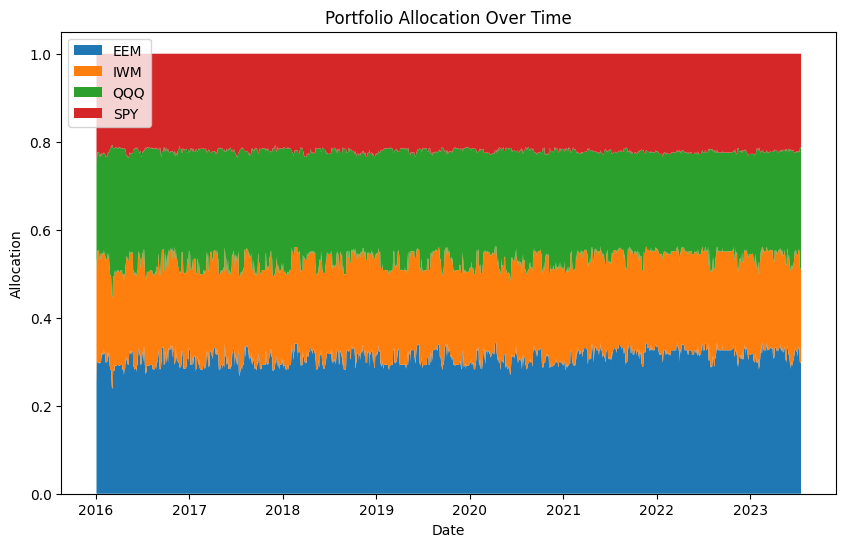

In [ ]:
%matplotlib inline
show_weight_distribution(df_actions)

Baselinestats

In [ ]:
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1896, 8)
Annual return          0.097721
Cumulative returns     1.016763
Annual volatility      0.187859
Sharpe ratio           0.591104
Calmar ratio           0.263498
Stability              0.867164
Max drawdown          -0.370862
Omega ratio            1.127696
Sortino ratio          0.818636
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.922669
Daily value at risk   -0.023227
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1884, 8)


Start date,2016-01-04
End date,2023-06-28
Total months,89
,Backtest
Annual return,9.589%
Cumulative returns,98.286%
Annual volatility,19.909%
Sharpe ratio,0.56
Calmar ratio,0.29
Stability,0.78
Max drawdown,-33.235%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,33.23,2020-02-19,2020-03-23,2020-08-04,120
1,30.74,2021-11-08,2022-10-14,NaT,NaN
2,20.80,2018-01-26,2018-12-24,2019-11-04,462
3,10.55,2016-01-05,2016-02-11,2016-03-11,49
4,8.77,2020-09-02,2020-09-23,2020-10-12,29


Stress Events,mean,min,max
New Normal,0.06%,-4.50%,2.99%
Covid,0.04%,-12.20%,8.30%


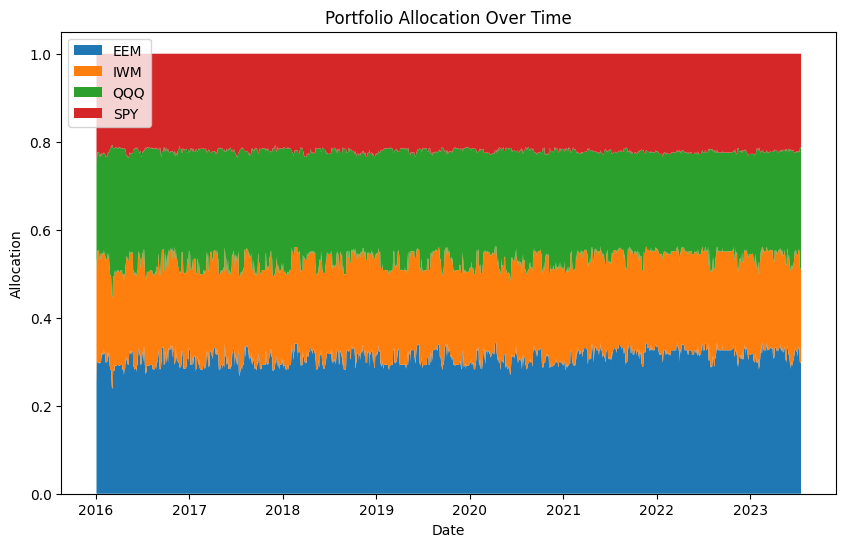

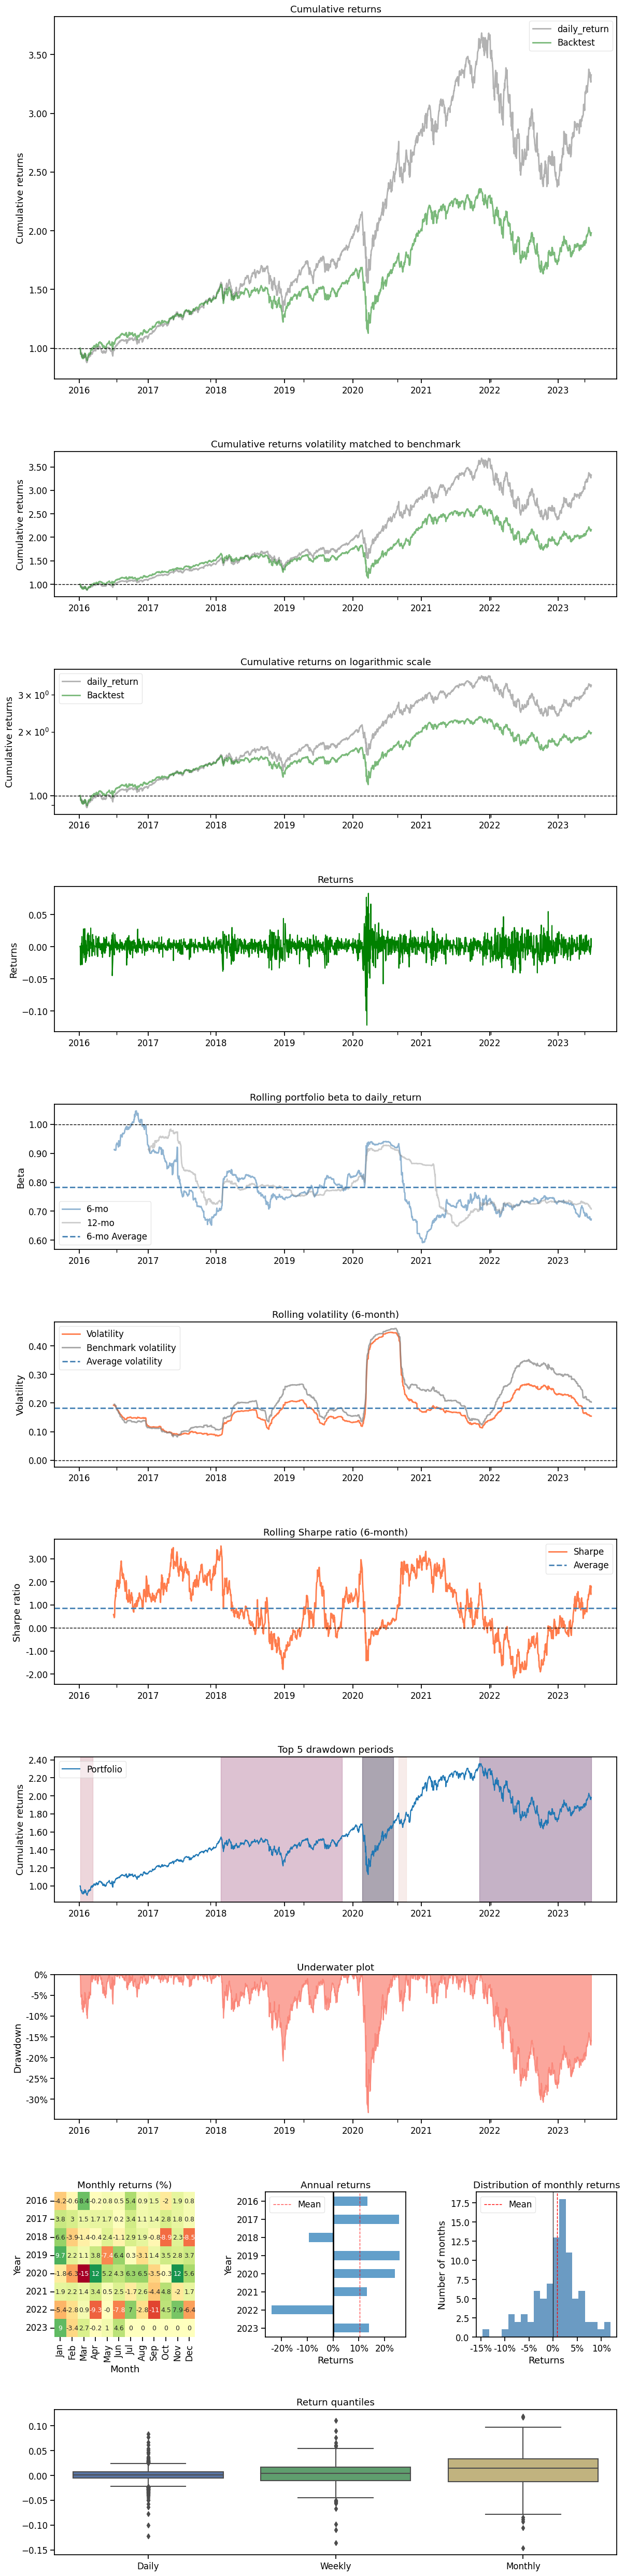

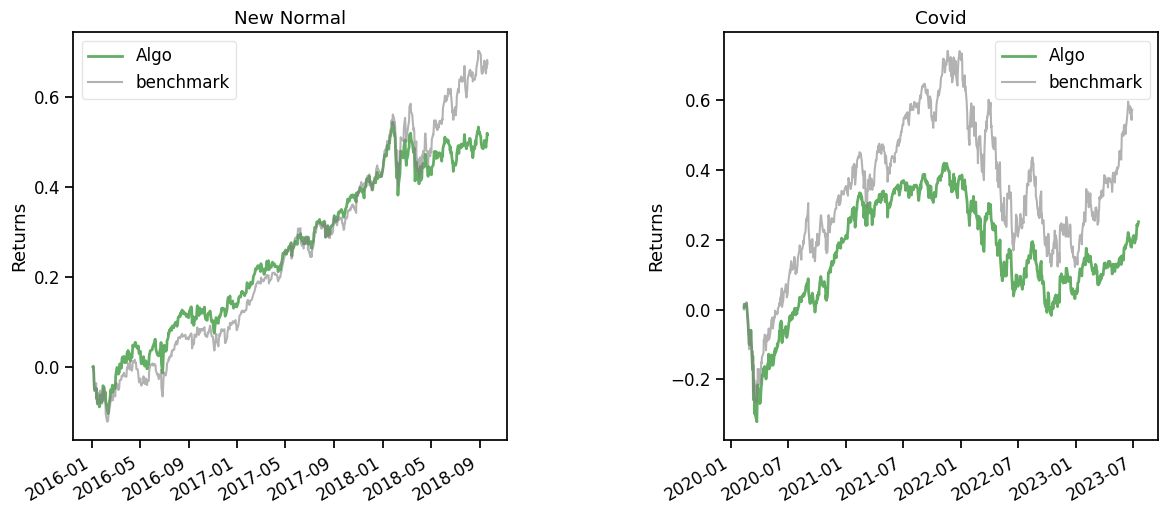

In [ ]:
%matplotlib inline
baseline_df = get_baseline(
        ticker='^NDX', start=df_daily_return.loc[0,'date'], end='2023-06-29'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
        
                                       benchmark_rets=baseline_returns, set_context=False)